# Figure 3. Steady-state and oscillations

Copyright (C) 2023 Robert Gowers and Magnus Richardson

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public
License as published by the Free Software Foundation; either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, see <https://www.gnu.org/licenses>.

---   

In [1]:
# Packages
using PyPlot
using DelimitedFiles
using Statistics
using Distributions  

# Load general functions and model parameters
include("CommonCode.jl");


------------------------------------------
EL=-60.0 	Ee=0.0  	Ei=-80.0
tauL=40.0 	taue=3.0 	taui=10.0
lamL=224.0 	lame=19.0 	lami=64.0
		game=0.1 	gami=0.1

kappa=0.6 tau0=24.0
D=1250.0
Vth=-50.0 Vre=-60.0
L=2000.0
------------------------------------------



---   

# (i) Theory 

In [2]:
###############################################################
# Grid for the mean-voltage range and aproproiate rates.
###############################################################

# Grid for the mean-voltage range and aproproiate rates.
dEthe=0.05;

aL=1/tauL; a0=aL/kappa
EElo=Ei+kappa*(EL-Ei)
EEhi=Ee-kappa*(Ee-EL)

EEthe=collect(maximum([EL,EElo]):dEthe:minimum([Vth,EEhi]))
nEEthe=length(EEthe)

aaethe=((EEthe .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei)
aaithe=((Ee .-EEthe)*a0 .- aL*(Ee-EL))/(Ee-Ei);

# Theoretical predictions
PV0EEthe,Pvv0EEthe,Pdvdv0EEthe,Pru0EEthe,Pvhe0EEthe,Pvhi0EEthe=(zeros(nEEthe) for j=1:6)
DV0EEthe,Dvv0EEthe,Ddvdv0EEthe,Dru0EEthe,Dvhe0EEthe,Dvhi0EEthe=(zeros(nEEthe) for j=1:6)

for k=1:nEEthe
    PV0EEthe[k],Pvhe0EEthe[k],Pvhi0EEthe[k],Pvv0EEthe[k],Pdvdv0EEthe[k],Pru0EEthe[k]=PointSteadyTheory(aaethe[k],aaithe[k]);
    DV0EEthe[k],Dvhe0EEthe[k],Dvhi0EEthe[k],Dvv0EEthe[k],Ddvdv0EEthe[k],Dru0EEthe[k]=DendrSteadyTheory(aaethe[k],aaithe[k]);
end

###############################################################
# Details for a particular case
###############################################################
# rstarHz provided in CommonCode
rstar=rstarHz/K
GetxStar(x1,x2,y1,y2,ystar)=x1 + (x2-x1)*(ystar-y1)/(y2-y1)

sD2=minimum(findall(Dru0EEthe.>rstar)); sD1=sD2-1
DEstar=GetxStar(EEthe[sD1],EEthe[sD2],Dru0EEthe[sD1],Dru0EEthe[sD2],rstar)

# Get the various upcrossing parameters for these values
Daestar=((DEstar .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei)
Daistar=((Ee .-DEstar)*a0 .- aL*(Ee-EL))/(Ee-Ei);
DV0Esthe,Dvhe0Esthe,Dvhi0Esthe,Dvv0Esthe,Ddvdv0Esthe,Dru0Esthe=DendrSteadyTheory(Daestar,Daistar);

# Match the point moments
Paestar=Daestar
Paistar=Daistar
PV0Esthe,Pvhe0Esthe,Pvhi0Esthe,Pvv0Esthe,Pdvdv0Esthe,Pru0Esthe=PointSteadyTheory(Paestar,Paistar);

println("Dendr E*=$(round(DEstar,digits=2))mV for rate=$(K*rstar)Hz")

mu,sig=DV0Esthe,sqrt(Dvv0Esthe)

###############################################################
# Theory for the oscillations 
###############################################################
# Get the theory
fHzTH=10.0.^(range(log10(0.1),stop=log10(10000),length=6121))
fkHzTH=fHzTH/1000.0
wTH=2*pi*fkHzTH
nfTH=length(wTH)

# Run for the point case
PV0,Pvv0,Pdvdv0,PV1,PdVdt1,Pvhe1,Pvhi1,Pvv1,Pvdv1,Pdvdv1,Pru1=PointOscTheory(Paestar,Paistar,fkHzTH);
Pvhe1L,Pvhi1L,Pvv1L,Pdvdv1L,PrU1L,PdVdt1H,Pvhe1H,Pvhi1H,Pvdv1H,Pdvdv1H,PrU1H=PointOscAsym(Paestar,Paistar,fkHzTH);

# Run for the dendrite case
DV0,Dvv0,Ddvdv0,DV1,DdVdt1,Dvhe1,Dvhi1,Dvv1,Dvdv1,Ddvdv1,Dru1=DendrOscTheory(Daestar,Daistar,fkHzTH);
Dvhe1L,Dvhi1L,Dvv1L,Ddvdv1L,DrU1L,DdVdt1H,Dvhe1H,Dvhi1H,Dvdv1H,Ddvdv1H,DrU1H=DendrOscAsym(Daestar,Daistar,fkHzTH);

sangle=findall(angle.(Pru1).>angle.(Dru1))
snamp=findall(abs.(Pru1/Pru1[1]).>abs.(Dru1/Dru1[1]))

length(sangle)>0 ? fangle=round(fHzTH[maximum(sangle)],digits=1) : fangle=0
length(snamp)>0 ?  fnamp=round(fHzTH[maximum(snamp)],digits=1) : fnamp=0

#fangle=round(fHzTH[maximum(findall(angle.(Pru1).>angle.(Dru1)))],digits=1)
#fnamp=round(fHzTH[maximum(findall(abs.(Pru1/Pru1[1]).>abs.(Dru1/Dru1[1])))],digits=1)
println("Cross overs. amp: $(fnamp)Hz angle: $(fangle)Hz ")

Dendr E*=-57.12mV for rate=5.0Hz
Cross overs. amp: 247.6Hz angle: 40.8Hz 


In [3]:
# autocovariances

dxthe=1.0;
xthe=collect(-L:dxthe:L);

vhe0xthe,vhi0xthe,vv0xthe,dvdv0xthe=DendrCovarianceSteadyTheory(xthe,Daestar,Daistar);


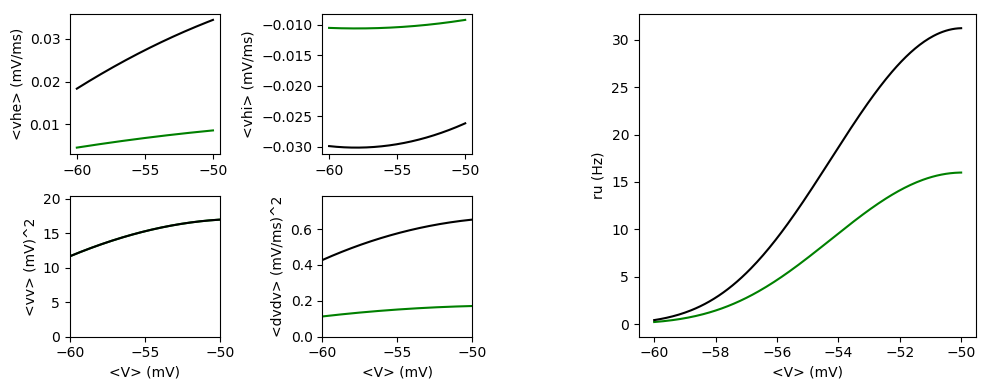

In [4]:
# plot out steady-state quantities

figure(figsize=(10,4))
    ScP="g-"
    ScD="k-"
    
    #subplot(231); ylabel("<V>")
    plot(EEthe,PV0EEthe,ScP,EEthe,DV0EEthe,ScD)
    
    subplot(241); ylabel("<vhe> (mV/ms)")
    plot(EEthe,Pvhe0EEthe,ScP,EEthe,Dvhe0EEthe,ScD)
    
    subplot(242); ylabel("<vhi> (mV/ms)")
    plot(EEthe,Pvhi0EEthe,ScP,EEthe,Dvhi0EEthe,ScD)
    
    subplot(245); ylabel("<vv> (mV)^2"); xlabel("<V> (mV)")
    plot(EEthe,Pvv0EEthe,ScP,EEthe,Dvv0EEthe,ScD)
    axis([EEthe[1],EEthe[end],0,1.2*maximum(Dvv0EEthe)])
    
    subplot(246); ylabel("<dvdv> (mV/ms)^2"); xlabel("<V> (mV)")
    plot(EEthe,Pdvdv0EEthe,ScP,EEthe,Ddvdv0EEthe,ScD)
    axis([EEthe[1],EEthe[end],0,1.2*maximum(Ddvdv0EEthe)])
    
    subplot(122); ylabel("ru (Hz)"); xlabel("<V> (mV)")
    plot(EEthe,K*Pru0EEthe,ScP,EEthe,K*Dru0EEthe,ScD)

    tight_layout()

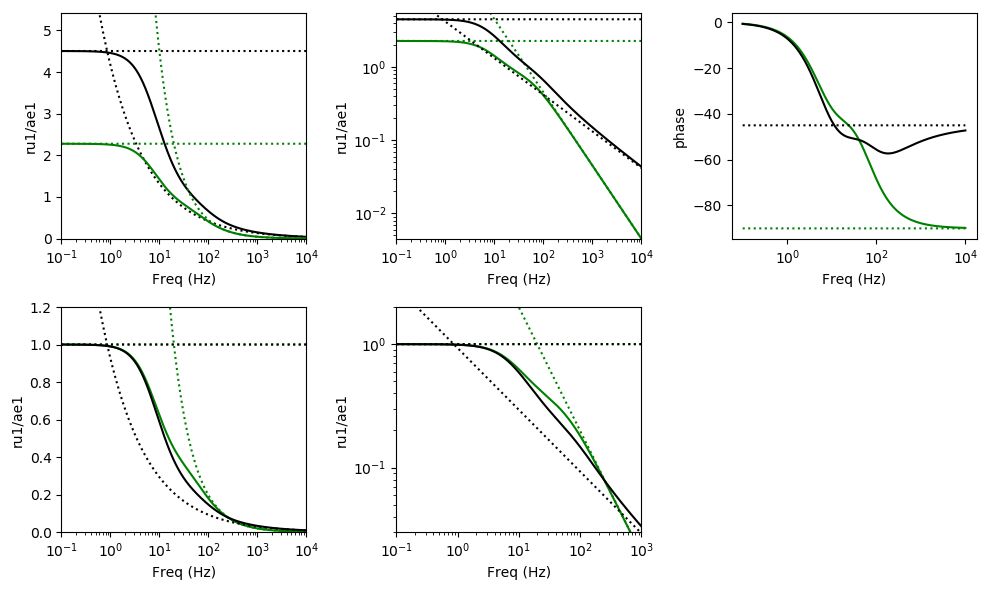

In [5]:
###############################################################
# Plot out the theoretical quantities
###############################################################

pygui(false)
figure(figsize=(10,6))

subplot(231); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
semilogx(fHzTH,abs.(Dru1),"k-",fHzTH,DrU1L,"k:",fHzTH,abs.(DrU1H),"k:"); 
semilogx(fHzTH,abs.(Pru1),"g-",fHzTH,PrU1L,"g:",fHzTH,abs.(PrU1H),"g:"); 
axis([fHzTH[1],fHzTH[end],0,1.2*maximum(abs.(Dru1))])

subplot(232); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
loglog(fHzTH,abs.(Pru1),"g-",fHzTH,PrU1L,"g:",fHzTH,abs.(PrU1H),"g:")
loglog(fHzTH,abs.(Dru1),"k-",fHzTH,DrU1L,"k:",fHzTH,abs.(DrU1H),"k:"); 
axis([fHzTH[1],fHzTH[end],minimum(abs.(PrU1H)),1.2*maximum(abs.(Dru1))])

subplot(233); xlabel("Freq (Hz)"); ylabel("phase")
semilogx(fHzTH,r2d*angle.(Pru1),"g-",fHzTH,r2d*angle.(PrU1H),"g:");
semilogx(fHzTH,r2d*angle.(Dru1),"k-",fHzTH,r2d*angle.(DrU1H),"k:");

subplot(234); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
semilogx(fHzTH,abs.(Pru1/Pru1[1]),"g-",fHzTH,PrU1L/abs(Pru1[1]),"g:",fHzTH,abs.(PrU1H)/abs(Pru1[1]),"g:")
semilogx(fHzTH,abs.(Dru1/Dru1[1]),"k-",fHzTH,DrU1L/abs(Dru1[1]),"k:",fHzTH,abs.(DrU1H)/abs(Dru1[1]),"k:")
axis([fHzTH[1],fHzTH[end],0,1.2])

subplot(235); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
loglog(fHzTH,abs.(Pru1/Pru1[1]),"g-",fHzTH,PrU1L/abs(Pru1[1]),"g:",fHzTH,abs.(PrU1H)/abs(Pru1[1]),"g:")
loglog(fHzTH,abs.(Dru1/Dru1[1]),"k-",fHzTH,DrU1L/abs(Dru1[1]),"k:",fHzTH,abs.(DrU1H)/abs(Dru1[1]),"k:")
axis([fHzTH[1],fHzTH[end],minimum(abs.(PrU1H)),2]);
axis([fHzTH[1],1000,0.03,2]);

tight_layout()


---   

# (ii) Steady-state simulations  

In [6]:
# Choices for the simulation grid
#dt=0.005; dx=10;
dt=0.02; dx=20;
#dt=0.04; dx=25
#dt=0.2; dx=50;

T=1000;

t=collect(dt:dt:T); nt=length(t); 
x=collect(dx:dx:L); nx=length(x);


In [7]:
# Grid for the mean-voltage range and aproproiate rates.
dEsim=1.0;
EEsim=collect(EL:dEsim:Vth)
nEEsim=length(EEsim)
aL=1/tauL; a0=aL/kappa
aae=((EEsim .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei)
aai=((Ee .-EEsim)*a0 .- aL*(Ee-EL))/(Ee-Ei);

In [8]:
# Simulation predictions
# U means up-crossing with gaussian synaptic but cross-terms in voltage
# V means threshold reset
# u mueas up-crossing full gaussian approx

Pru0EEsim,Puu0EEsim,Puhe0EEsim,Puhi0EEsim,Pdudu0EEsim=(zeros(nEEsim) for j=1:5)
Lru0EEsim,Luu0EEsim,Luhe0EEsim,Luhi0EEsim,Ldudu0EEsim=(zeros(nEEsim) for j=1:5)

ns=20; # number of sweeps

@time for k=1:nEEsim

    aet,ait=aae[k]*ones(nt),aai[k]*ones(nt) # stretch constant values to the time support
    
    # Point neuron guassian sims
    Pru0EEsimt,Puu0EEsimt,Puhe0EEsimt,Puhi0EEsimt,Pdudu0EEsimt=PointSweeps(t,aet,ait,ns);
    Pru0EEsim[k]=sum(Pru0EEsimt*dt/T); 
    Puu0EEsim[k]=mean(Puu0EEsimt); 
    Puhe0EEsim[k]=mean(Puhe0EEsimt); 
    Puhi0EEsim[k]=mean(Puhi0EEsimt); 
    Pdudu0EEsim[k]=mean(Pdudu0EEsimt); 
    
    # Loop around dendrite sim
    Lru0EEsimt,Luu0EEsimt,Luhe0EEsimt,Luhi0EEsimt,Ldudu0EEsimt=DendrSweeps(x,t,aet,ait,ns);
    Lru0EEsim[k]=sum(Lru0EEsimt*dt/T); 
    Luu0EEsim[k]=mean(Luu0EEsimt); 
    Luhe0EEsim[k]=mean(Luhe0EEsimt); 
    Luhi0EEsim[k]=mean(Luhi0EEsimt); 
    Ldudu0EEsim[k]=mean(Ldudu0EEsimt); 
end

301.250759 seconds (705.21 M allocations: 435.239 GiB, 28.17% gc time)


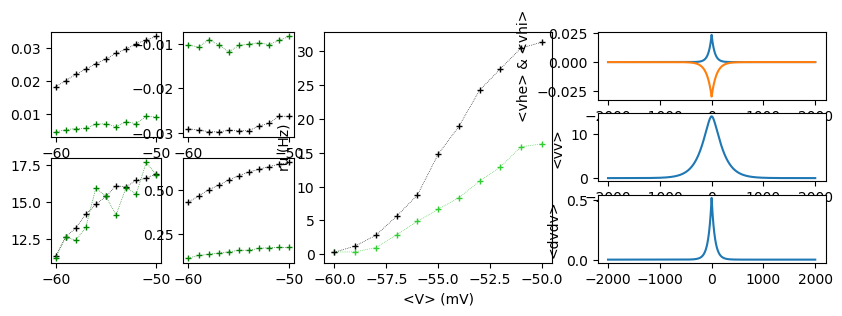

In [9]:
figure(figsize=(10,3))

ms=5
lw=0.5

subplot(261)
plot(EEsim,Luhe0EEsim,"k+:",markersize=ms,linewidth=lw)
plot(EEsim,Puhe0EEsim,"g+:",markersize=ms,linewidth=lw)

subplot(262)
plot(EEsim,Luhi0EEsim,"k+:",markersize=ms,linewidth=lw)
plot(EEsim,Puhi0EEsim,"g+:",markersize=ms,linewidth=lw)

subplot(267)
plot(EEsim,Luu0EEsim,"k+:",markersize=ms,linewidth=lw)
plot(EEsim,Puu0EEsim,"g+:",markersize=ms,linewidth=lw)

subplot(268)
plot(EEsim,Ldudu0EEsim,"k+:",markersize=ms,linewidth=lw)
plot(EEsim,Pdudu0EEsim,"g+:",markersize=ms,linewidth=lw)

subplot(132); ylabel("ru (Hz)"); xlabel("<V> (mV)")
ms2=4
plot(EEsim,K*Pru0EEsim,"+g:",color="limegreen",markersize=ms2,linewidth=lw,label="gauss uc");
plot(EEsim,K*Lru0EEsim,"+k:",markersize=ms2,linewidth=lw);

subplot(333)
plot(xthe,vhe0xthe,xthe,vhi0xthe)
ylabel("<vhe> & <vhi>")

subplot(336)
plot(xthe,vv0xthe)
ylabel("<vv>")

subplot(339)
plot(xthe,dvdv0xthe)
ylabel("<dvdv>")

tight_layout()

---   

# (iii) Oscillatory simulations     

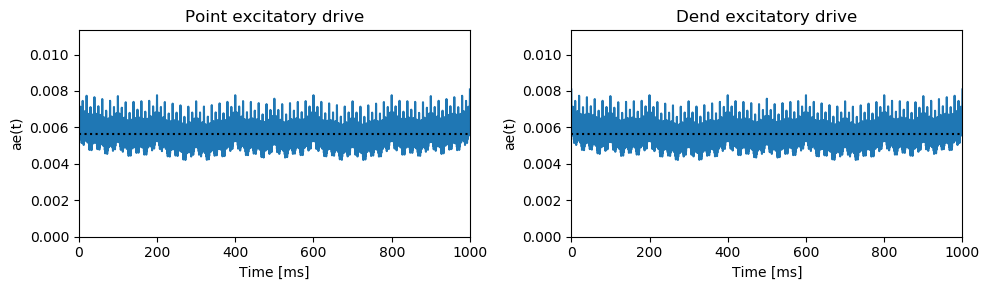

In [17]:
###############################################################
# Frequency range for simulations
###############################################################

# These need to have an integer number of periods within 1 second
fHzsim=[1,2,5,10,20,50,100,200,500,1000]
fkHzsim=fHzsim/1000.0
wsim=2*pi*fkHzsim
nfsim=length(wsim);

# Amplitudes: allows for a frequency-dependent distribution if needed
q=1.5 # global factor

Pae1sim=q*0.015*Paestar*ones(nfsim);
Dae1sim=q*0.015*Daestar*ones(nfsim);

Pae1sim[end-4:end].=q*0.03*Paestar
Dae1sim[end-4:end].=q*0.03*Daestar

Pae1sim[end-2:end].=q*0.05*Paestar
Dae1sim[end-2:end].=q*0.05*Daestar

# create the stimulation rates for the point and dendrite cases
Paet,Pait=Paestar*ones(nt),Paistar*ones(nt)
Daet,Dait=Daestar*ones(nt),Daistar*ones(nt)
for k=1:nfsim 
    Paet=Paet .+ Pae1sim[k]*cos.(wsim[k]*t)
    Daet=Daet .+ Dae1sim[k]*cos.(wsim[k]*t)
end

###############################################################
# Plots out the stimulation to check deviations are too high
###############################################################
pygui(false); figure(figsize=(10,3)); 

subplot(121); ylabel("ae(t)"); title("Point excitatory drive"); xlabel("Time [ms]");
plot(t,Paet); plot([0,T],Paestar*[1,1],"k:"); axis([0,T,0,Paestar*2.0]); 

subplot(122); ylabel("ae(t)"); title("Dend excitatory drive"); xlabel("Time [ms]");
plot(t,Daet); plot([0,T],Daestar*[1,1],"k:"); axis([0,T,0,Daestar*2.0]); 

tight_layout()

In [11]:
###############################################################
# Run parameters 
# nr = global repeats. nSD, nSP=number of dendrite/point
###############################################################

#nsD=400; nsP=4000; nr=80
#nsD=400; nsP=4000; nr=40
#nsD=200; nsP=2000; nr=20 
#nsD=100; nsP=1000; nr=10
#nsD=50; nsP=500; nr=5
nsD=20; nsP=200; nr=2

Pmrutr=zeros(nt,nr)
Lmrutr=zeros(nt,nr)

@time Pmrutr[:,1],~,~,~,~=PointSweeps(t,Paet,Pait,nsP);
@time Lmrutr[:,1],~,~,~,~=DendrSweeps(x,t,Daet,Dait,nsD);

print("Done: ")
for k=2:nr
    Pmrutr[:,k],~,~,~,~=PointSweeps(t,Paet,Pait,nsP);
    Lmrutr[:,k],~,~,~,~=DendrSweeps(x,t,Daet,Dait,nsD)
    print(" $k")
end

Pru1t=mean(Pmrutr,dims=2);
Lru1t=mean(Lmrutr,dims=2);

# check for non-linearities
K*mean(Lru1t),K*mean(Pru1t)

  2.574885 seconds (115.96 k allocations: 2.623 GiB, 16.53% gc time)
 27.178939 seconds (64.05 M allocations: 39.291 GiB, 28.30% gc time)
Done:  2

(5.429500000000001, 2.505)

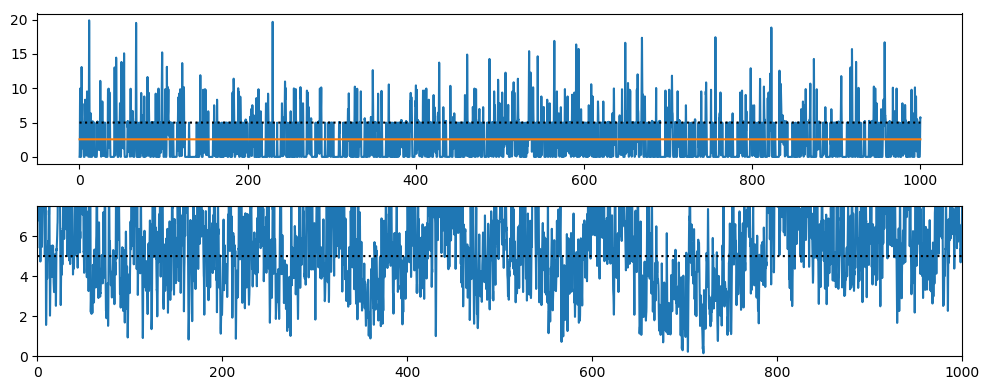

mean ruc=5.43Hz
dt=0.02 dx=20 nsD=20 nsP=200 nr=2


In [12]:
###############################################################
# Plots to check for mean deviations from steady state
###############################################################

pygui(false); figure(figsize=(10,4)); 

# Smooth the data for plot
eps=0.1; tS=1.0; nS=Int(round(tS/(dt*eps),digits=0))

Pru1tS=Smooth(Pru1t,nS,eps)
Lru1tS=Smooth(Lru1t,nS,eps)
unot=ones(size(t))

# Plots
subplot(211)
plot(t,K*Pru1tS); plot(t,unot*5,"k:")
plot(t,K*Pru0Esthe*ones(size(t)))
#axis([0,1000,0,rstar*K*1.5])
subplot(212)
plot(t,K*Lru1tS); plot(t,unot*5,"k:")
axis([0,1000,0,rstar*K*1.5])

tight_layout()

println("mean ruc=$(round(mean(K*Lru1t),digits=2))Hz")
println("dt=$dt dx=$dx nsD=$nsD nsP=$nsP nr=$nr")

In [19]:
# Create arrays for oscillatory fits and extract from time series data
# We drop the sim subscript here

(Pru1m,Pru1a,Pru1p)=(zeros(nfsim) for i=1:3) # the upcrossing gaussian approx
(Lru1m,Lru1a,Lru1p)=(zeros(nfsim) for i=1:3) # Loop dendrite

for k=1:nfsim
    Pru1m[k],Pru1a[k],Pru1p[k]=MyCosFitSim(t,Pru1t,wsim[k]) # fits to upcrossing gaussian approx
    Lru1m[k],Lru1a[k],Lru1p[k]=MyCosFitSim(t,Lru1t,wsim[k]) # loop dendrite
end 

# tidy up with respect to the frequency-dependent amplitudes
Pru1aN=Pru1a./Pae1sim
Lru1aN=Lru1a./Dae1sim;

## Plot linearised upcrossing method    

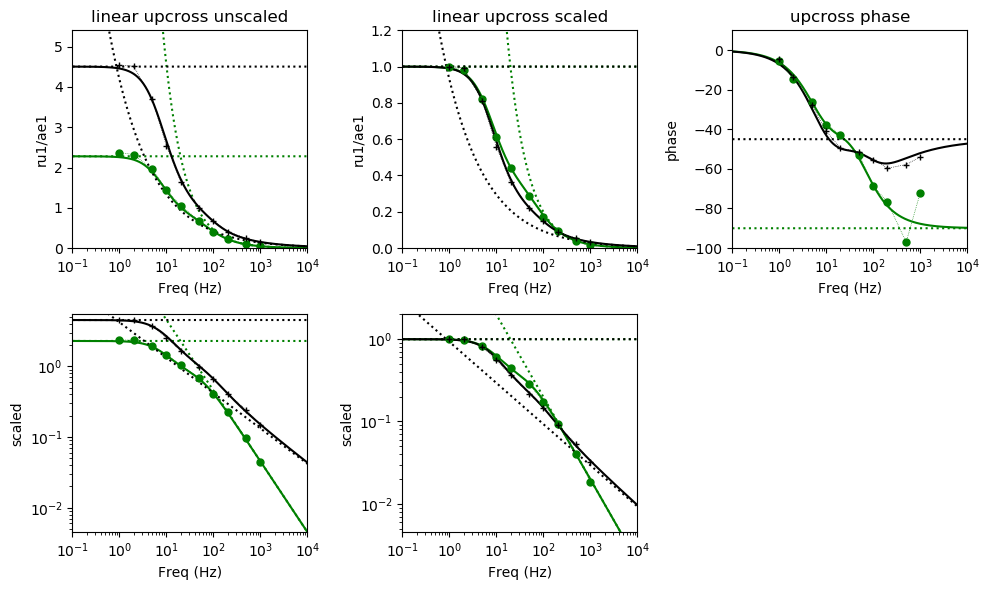

In [20]:
# compares theory with the guassian approx upcrossing method
pygui(false)
figure(figsize=(10,6))
lw, ms=0.5,5

#########################################################
# Upcrossing method
#########################################################
subplot(231); title("linear upcross unscaled"); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
semilogx(fHzTH,abs.(Pru1),"g-",fHzTH,PrU1L,"g:",fHzTH,abs.(PrU1H),"g:"); 
semilogx(fHzTH,abs.(Dru1),"k-",fHzTH,DrU1L,"k:",fHzTH,abs.(DrU1H),"k:"); 
semilogx(fHzsim,Pru1aN,"go:",linewidth=lw,markersize=ms)
semilogx(fHzsim,Lru1aN,"k+:",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],0,1.2*maximum(abs.(Dru1))])

subplot(234); xlabel("Freq (Hz)"); ylabel("scaled")
loglog(fHzTH,abs.(Pru1),"g-",fHzTH,PrU1L,"g:",fHzTH,abs.(PrU1H),"g:")
loglog(fHzTH,abs.(Dru1),"k-",fHzTH,DrU1L,"k:",fHzTH,abs.(DrU1H),"k:"); 
loglog(fHzsim,Pru1aN,"go:",linewidth=lw,markersize=ms)
loglog(fHzsim,Lru1aN,"k+:",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],minimum(abs.(PrU1H)),1.2*maximum(abs.(Dru1))])

#########################################################
# Upcrossing method scaled to be 1 at 0 freq
#########################################################
subplot(232); title("linear upcross scaled"); xlabel("Freq (Hz)"); ylabel("ru1/ae1")
semilogx(fHzTH,abs.(Pru1/Pru1[1]),"g-",fHzTH,PrU1L/abs(Pru1[1]),"g:",fHzTH,abs.(PrU1H)/abs(Pru1[1]),"g:")
semilogx(fHzTH,abs.(Dru1/Dru1[1]),"k-",fHzTH,DrU1L/abs(Dru1[1]),"k:",fHzTH,abs.(DrU1H)/abs(Dru1[1]),"k:")
semilogx(fHzsim,Pru1aN/Pru1aN[1],"go:",linewidth=lw,markersize=ms)
semilogx(fHzsim,Lru1aN/Lru1aN[1],"k+:",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],0,1.2])

subplot(235); xlabel("Freq (Hz)"); ylabel("scaled")
loglog(fHzTH,abs.(Pru1/Pru1[1]),"g-",fHzTH,PrU1L/abs(Pru1[1]),"g:",fHzTH,abs.(PrU1H)/abs(Pru1[1]),"g:")
loglog(fHzTH,abs.(Dru1/Dru1[1]),"k-",fHzTH,DrU1L/abs(Dru1[1]),"k:",fHzTH,abs.(DrU1H)/abs(Dru1[1]),"k:")
loglog(fHzsim,Pru1aN/Pru1aN[1],"go:",linewidth=lw,markersize=ms)
loglog(fHzsim,Lru1aN/Lru1aN[1],"k+:",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],minimum(abs.(PrU1H)),2]);

#########################################################
# The phase
#########################################################
subplot(233); title("upcross phase"); xlabel("Freq (Hz)"); ylabel("phase")
semilogx(fHzTH,r2d*angle.(Pru1),"g-",fHzTH,r2d*angle.(PrU1H),"g:");
semilogx(fHzTH,r2d*angle.(Dru1),"k-",fHzTH,r2d*angle.(DrU1H),"k:");
semilogx(fHzsim,r2d*Pru1p,"go:",linewidth=lw,markersize=ms)
semilogx(fHzsim,r2d*Lru1p,"k+:",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],-100,10])

tight_layout()

# (iii) Figure 3 code    

In [7]:
#########################################################
# Figure 3
#########################################################

pygui(true)
fig=figure(figsize=1.6.*(7.025,2))

panelfs=14
labelfs=8
tickfs=8
lw=1.0
ms=3

##################################################################
# Positions
##################################################################
bx,tx=0.05,0.98 # top and bottom x edges
by,ty=0.175,0.9 # top and bottom y edges
wy=(ty-by)
gy=0.075
hA=(ty-by-2*gy)/3
hC,hD,hE=(ty-by).*(1,1,1)

gAB=0.05
gBC=0.06
gCD=0.06
gDE=0.06
w2=0.18 # width of panesl C, D and E
w1=(tx-bx-gAB-gBC-gCD-gDE-3*w2)/2

xA=bx
xB=bx+w1+gAB
xC=bx+2*w1+gAB+gBC
xD=bx+2*w1+gAB+w2+gBC+gCD
xE=tx-w2
yA1,yA2,yA3=by, by+hA+gy, by+2*(hA+gy)
yB1,yB2,yB3=by, by+hA+gy, by+2*(hA+gy)
yC,yD,yE=by.*(1,1,1)

#########################################################
# Panel A. Covariances
#########################################################
fig.text(xA-0.04, 0.95, "A", fontsize=panelfs)

axA3=plt.axes([xA,yA3,w1,hA]); 
plot(xthe,vhe0xthe,"g-",xthe,vhi0xthe,"r-",linewidth=lw)
ylabel(L"$\langle vh_e \rangle$ & $\langle vh_i \rangle$",fontsize=labelfs)
axis([-1000,1000,-0.04,0.04])
xticks(fontsize=tickfs);
axA3.set_yticks([-0.04,0,0.04])
axA3.set_yticklabels(["-0.04","0","0.04"],rotation=90,fontsize=tickfs)
text(-300,0.01,"e",fontsize=tickfs)
text(200,-0.02,"i",fontsize=tickfs)

axA2=plt.axes([xA,yA2,w1,hA]); 
plot(xthe,vv0xthe,"k-",linewidth=lw)
ylabel(L"$\langle v^2 \rangle$",fontsize=labelfs)
axis([-1000,1000,0,1.1*maximum(vv0xthe)])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)

axA1=plt.axes([xA,yA1,w1,hA]); 
plot(xthe,dvdv0xthe,"k-",linewidth=lw)
axis([-1000,1000,0,1.1*maximum(dvdv0xthe)])
ylabel(L"$\langle \dot{v}^2\rangle$",fontsize=labelfs); 
xlabel(L"x ($\mu$m)",fontsize=labelfs)
xticks(fontsize=tickfs);yticks(fontsize=tickfs)

#########################################################
# Panel B. Subthreshold params
#########################################################
fig.text(xB-0.04, 0.95, "B",fontsize=panelfs)

axB3=plt.axes([xB,yA3,w1,hA]); 
ylabel(L"$\alpha_\mathrm{e}$, $\alpha_\mathrm{i}$",fontsize=labelfs)
plot(EEthe,aaethe,linewidth=lw,"g")
plot(EEthe,aaithe,linewidth=lw,"r")
axis([EEthe[1],EEthe[end],0,0.02])
xticks(fontsize=tickfs); yticks(fontsize=tickfs)
axB3.set_yticks([0,0.01,0.02])
axB3.set_yticklabels(["0","0.01","0.02"],rotation=90,fontsize=tickfs)
text(-55,0.003,"e",fontsize=tickfs)
text(-55,0.012,"i",fontsize=tickfs)

axB2=plt.axes([xB,yA2,w1,hA]); 
ylabel(L"\langle v^2 \rangle",fontsize=labelfs)
plot(EEthe,Pvv0EEthe,ScP,EEthe,Dvv0EEthe,ScD,linewidth=lw)
#plot(EEsim,Luu0EEsim,"k+",markersize=ms,linewidth=lw)
axis([EEthe[1],EEthe[end],10,20])
axB2.set_yticks([10,15,20])
axB2.set_yticklabels(["10","15","20"],fontsize=tickfs)
text(-56,12,"dend & iso",fontsize=tickfs)

axB1=plt.axes([xB,yA1,w1,hA]); 
ylabel(L"\langle \dot{v}^2 \rangle",fontsize=labelfs);
xlabel(L"\langle V \rangle",fontsize=labelfs)
plot(EEthe,Pdvdv0EEthe,"b-",EEthe,Ddvdv0EEthe,"k-",linewidth=lw)
#plot(EEsim,Ldudu0EEsim,"k+",markersize=ms,linewidth=lw)
axis([EEthe[1],EEthe[end],0,0.8])
axB1.set_yticks([0,0.4,0.8])
axB1.set_yticklabels(["0","0.4","0.8"],fontsize=tickfs)
text(-58,0.7,"dend",fontsize=tickfs)
text(-58,0.2,"iso",fontsize=tickfs)

#########################################################
# Panel C. Upcrossing rate
#########################################################
fig.text(xC-0.04, 0.95, "C",fontsize=panelfs)

axC=plt.axes([xC,yC,w2,hC]); 
ylabel("Upcrossing rate (Hz)",fontsize=labelfs);
xlabel(L"Mean voltage $\langle V \rangle$ (mV)",fontsize=labelfs)
plot(EEthe,K*Pru0EEthe,"b",EEthe,K*Dru0EEthe,"k",linewidth=lw);
#plot(EEsim,K*Pru0EEsim,"ob",markersize=ms,linewidth=lw,label="gauss uc");
#plot(EEsim,K*Lru0EEsim,"+k",markersize=ms,linewidth=lw);
plot([-100,DEstar,DEstar],K*[rstar,rstar,0],"k:",linewidth=lw)
axis([EEthe[1],EEthe[end],0,1.1*maximum(K*Dru0EEthe)])
xticks(fontsize=tickfs); yticks(fontsize=tickfs)
axC.set_yticks([0,10,20,30])
text(-52.5,31,"dend",fontsize=tickfs)
text(-52.5,15,"iso",fontsize=tickfs)

#########################################################
# Panel D. Rate response and inset
#########################################################
fig.text(xD-0.04, 0.95, "D", fontsize=panelfs)

axD=plt.axes([xD,yD,w2,hD]);
loglog(fHzTH,abs.(Pru1),"b-",fHzTH,PrU1L,"b:",fHzTH,abs.(PrU1H),"b:",linewidth=lw)
loglog(fHzTH,abs.(Dru1),"k-",fHzTH,DrU1L,"k:",fHzTH,abs.(DrU1H),"k:",linewidth=lw); 
#loglog(fHzsim,Pru1aN,"bo",linewidth=lw,markersize=ms)
#loglog(fHzsim,Lru1aN,"k+",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],minimum(abs.(PrU1H)),1.2*maximum(abs.(Dru1))])
xlabel("Frequency (Hz)",fontsize=labelfs); 
ylabel("Rate response",fontsize=labelfs)
yticks(fontsize=tickfs)
xticks(fontsize=tickfs); 
text(1000,0.2,"dend",fontsize=tickfs)
text(1000,0.01,"iso",fontsize=tickfs)

wDI,hDI=0.075,0.35
axDI=plt.axes([xD+0.03,yD+0.10,wDI,hDI])
#xlabel("freq (Hz)",fontsize=labelfs); ylabel("scaled",fontsize=labelfs)
loglog(fHzTH,abs.(Pru1/Pru1[1]),"b-",fHzTH,PrU1L/abs(Pru1[1]),"b:",fHzTH,abs.(PrU1H)/abs(Pru1[1]),"b:",linewidth=lw)
loglog(fHzTH,abs.(Dru1/Dru1[1]),"k-",fHzTH,DrU1L/abs(Dru1[1]),"k:",fHzTH,abs.(DrU1H)/abs(Dru1[1]),"k:",linewidth=lw)
#loglog(fHzsim,Pru1aN/Pru1aN[1],"bo",linewidth=lw,markersize=ms)
#loglog(fHzsim,Lru1aN/Lru1aN[1],"k+",linewidth=lw,markersize=ms)
axis([1,1000,0.01,2]);
axDI.set_xticks([1,1000])
axDI.set_xticklabels(["1",L"$10^3$"],fontsize=tickfs)
yticks(rotation = 90,fontsize=tickfs)
xticks(fontsize=tickfs)

#########################################################
# Panel E. The phase
#########################################################
fig.text(xE-0.04, 0.95, "E", fontsize=panelfs)
axE=plt.axes([xE,yE,w2,hE]);

xlabel("Frequency (Hz)",fontsize=labelfs); 
ylabel("Phase (deg)",fontsize=labelfs)
semilogx(fHzTH,r2d*angle.(Pru1),"b-",fHzTH,r2d*angle.(PrU1H),"b:",linewidth=lw);
semilogx(fHzTH,r2d*angle.(Dru1),"k-",fHzTH,r2d*angle.(DrU1H),"k:",linewidth=lw);
#semilogx(fHzsim,r2d*Pru1p,"bo",linewidth=lw,markersize=ms)
#semilogx(fHzsim,r2d*Lru1p,"k+",linewidth=lw,markersize=ms)
axis([fHzTH[1],fHzTH[end],-95,10])
yticks(rotation = 0,fontsize=tickfs)
xticks(fontsize=tickfs); 
text(1000,-40,"dend",fontsize=tickfs)
text(1000,-85,"iso",fontsize=tickfs)

#########################################################
#########################################################
# Smarten panels
#########################################################
#########################################################

for ax in (axA1,axA2,axA3,axB1,axB2,axB3,axC,axD,axE)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

for ax in (axA2,axA3,axB2,axB3)
    ax.tick_params(labelbottom = false) 
end

savefig("Fig3.pdf")

In [49]:
close("all")